In [15]:
# Baseline model, doing logistic regression on the data
# Import pandas and sklearn

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder


In [28]:
df = pd.read_csv('data/train.csv')

# Split the data into training and testing data
# X = df.drop(['Exited', 'Surname', 'CustomerId', 'Gender', 'Geography'], axis=1)
df['SurnameLen'] = df['Surname'].apply(lambda x: len(x))
X = df.drop(['Exited', 'Surname', 'CustomerId'], axis=1)

In [29]:
X.describe()

,id,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,SurnameLen
count,165034.0000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,6.543179
std,47641.3565,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,2.614270
min,0.0000,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,2.000000
25%,41258.2500,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,5.000000
50%,82516.5000,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,6.000000
75%,123774.7500,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,8.000000
max,165033.0000,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,23.000000


In [3]:
# # one-hot encode the categorical variables (gender, geography)
# enc = OneHotEncoder(handle_unknown='ignore')
# X = enc.fit_transform(X).toarray()


In [4]:
# Describe the X dataframe
# pd.DataFrame(X).describe()

In [30]:
y = df['Exited']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# 
# scaler = StandardScaler().fit(X)
# 
# pipe = make_pipeline(StandardScaler(), LogisticRegression())
# pipe.fit(X_train, y_train)

In [ ]:
# pipe.score(X_test, y_test)

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Define column names for categorical and numeric columns
columns_to_drop = ['CustomerId']
categorical_columns = ['Gender', 'Geography']
numeric_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
                   'EstimatedSalary']

# Create the column preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(drop='first', categories='auto'), categorical_columns),
        ('std_scaler', StandardScaler(), numeric_columns)
    ])

# Create the pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('log_reg', LogisticRegression())
])

# Fit the pipeline to the data
pipe.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender', 'Geography']),
                                                 ('std_scaler',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary'])])),
                ('log_reg', LogisticRegression())])

In [33]:
# Make predictions
y_pred = pipe.predict(X_test)

Accuracy:  0.8354591450298422
ROC AUC:  0.6712712246247979
Confusion matrix:  [[24881  1171]
 [ 4260  2695]]


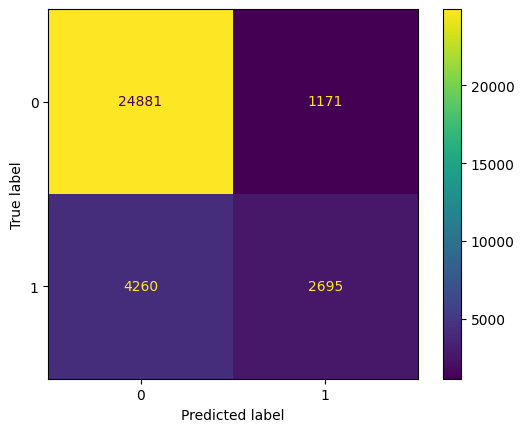

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC: ", roc_auc)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix: ", conf_matrix)
conf_plot = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                       display_labels=pipe.classes_)
conf_plot.plot()
plt.show()

0.8354591450298422